# Waves on an infinite string
We have to satisfy the momentum equation
\begin{align}
m(x)\frac{\partial^2 u}{\partial t^2} = \frac{\partial \sigma_{11}}{\partial x},\\
\sigma_{11}(x) = \kappa(x)\frac{\partial u}{\partial x},
\end{align}
where $u$ is the displacement in the $x$ direction and $\sigma_{11}$ the stress (force per unit area on a plane whose normal vector is the $x$ axis ($\sigma_{11}$ and $u$ should both be continuous). $\kappa$ is the elastic stiffness of the string.

If we have an infinite piece of string with different properties either side of $x=0$, we have to satisfy
\begin{align}
m_0 u_{tt} - \kappa_0 u_{xx} = 0\quad\textrm{for $x<0$},\\
m_1 u_{tt} - \kappa_1 u_{xx} = 0\quad\textrm{for $x>0$},\\
\kappa_0u_x(0^-) = \kappa_1u_x(0^+),\\
u(0^-) = u(0^+),\\
\end{align}
The governing equations are the wave equations
\begin{align}
&u_{tt} - c_i^2 u_{xx} = 0,\\
&c_i^2=\frac{\kappa_i}{m_i}.
\end{align}

## Time-harmonic solution
If $u(x,t) = \textrm{Re}\big[U(x)\textrm{e}^{-\textrm{i}\omega t}\big]$,
\begin{align}
&U_{xx} + k_i^2 U = 0,\\
&k_i^2=\frac{\omega^2}{c_i^2}=\frac{m_i\omega^2}{\kappa_i}.
\end{align}
The general solution is
\begin{align}
&U(x) = 
\begin{cases}
i^+\textrm{e}^{\textrm{i}k_0x} + s^+\textrm{e}^{-\textrm{i}k_0x} \quad\textrm{for $x<0$},\\
s^-\textrm{e}^{\textrm{i}k_1x} + i^-\textrm{e}^{-\textrm{i}k_1x} \quad\textrm{for $x>0$},
\end{cases}
\end{align}
with $i^\pm$ being (known) incident wave amplitudes and $s^\pm$ being (unknown) scattered wave amplitudes.
The boundary conditions imply that
\begin{align}
&i^+ + s^+ = i^- + s^-,\\
&\textrm{i}k_0\kappa_0(i^+ - s^+) = -\textrm{i}k_1\kappa_1(i^- - s^-).
\end{align}

Hence
\begin{align}
\begin{pmatrix}
1 & -1\\
-\textrm{i}k_0\kappa_0 & -\textrm{i}k_1\kappa_1
\end{pmatrix}
\begin{pmatrix}
s^+\\ s^-
\end{pmatrix}
=
\begin{pmatrix}
-1 & 1\\
-\textrm{i}k_0\kappa_0 & -\textrm{i}k_1\kappa_1
\end{pmatrix}
\begin{pmatrix}
i^+\\ i^-
\end{pmatrix},
\end{align}
so
\begin{align}
&\begin{pmatrix}
s^+ \\ s^-
\end{pmatrix} = 
\frac{1}{k_0\kappa_0+k_1\kappa_1}
\begin{pmatrix}
k_0\kappa_0 - k_1\kappa_1 & 2k_1\kappa_1 \\
2k_0\kappa_0 & k_1\kappa_1 - k_0\kappa_0
\end{pmatrix}
\begin{pmatrix}
i^+ \\ i^-
\end{pmatrix}
 = \begin{pmatrix}
R^+ & T^- \\
T^+ & R^-
\end{pmatrix}
\begin{pmatrix}
i^+ \\ i^-
\end{pmatrix}.
\end{align}
Note that the scattering is independent of wave period since $\omega$ factors in $k_0$ and $k_1$ cancel out.

## Energy conservation
The time-averaged power input to the piece of string is
\begin{align}
\mathcal{P}=\frac{\omega}{2\pi}\int_0^{2\pi/\omega}\big[\sigma_{11} u_t\big]^{x\rightarrow\infty}_{x\rightarrow-\infty}dt
\end{align}
in the absence of any work done at the boundary between the two bits of string, we expect this to be zero and this is shown below. Now
\begin{align}
\sigma_{11} u_t 
&= \textrm{Re}\big[S_{11}e^{-i\omega t}\big]\textrm{Re}\big[-i\omega Ue^{-i\omega t}\big]\\
&= \omega\big[\textrm{Re}[S_{11}]\cos(\omega t) + \textrm{Im}[S_{11}]\sin(\omega t)\big]
\big[\textrm{Im}[U]\cos(\omega t) - \textrm{Re}[U]\sin(\omega t)\big]\\
&=\frac\omega 2\big(\textrm{Re}[S_{11}]\,\textrm{Im}[U] - \textrm{Im}[S_{11}]\,\textrm{Re}[U]\big)\\
&\quad+\frac\omega 2\big(\textrm{Re}[S_{11}]\,\textrm{Im}[U] + \textrm{Im}[S_{11}]\,\textrm{Re}[U]\big)\cos(2\omega t)\\
&\quad+\frac\omega 2\big(\textrm{Re}[S_{11}]\,\textrm{Im}[U] - \textrm{Re}[S_{11}]\,\textrm{Im}[U]\big)\sin(2\omega t),
\end{align}
so
\begin{align}
\mathcal{P} &=\frac\omega 2\big[
\textrm{Re}[S_{11}]\,\textrm{Im}[U] - \textrm{Im}[S_{11}]\,\textrm{Re}[U]
\big]^{x\rightarrow\infty}_{x\rightarrow-\infty}\\
&= \frac{i\omega}4\big[
S_{11}U^* - S_{11}^*U
\big]^{x\rightarrow\infty}_{x\rightarrow-\infty}\\
&= \frac{i\omega}4\big[\kappa_i\big(
U_xU^* - U_x^*U\big)
\big]^{x\rightarrow\infty}_{x\rightarrow-\infty}\\
& = \frac{\omega}2k_1\kappa_1\big(|i^-|^2-|s^-|^2\big)
-\frac{\omega}2k_0\kappa_0\big(|s^+|^2-|i^+|^2\big).
\end{align}

Now it follows from the governing equations that
\begin{align}
0&=\int_{-\infty}^\infty\kappa_i\big(
(U_{xx}+k_i^2U)U^*
-
(U^{*}_{xx}+k_i^2U^*)U
\big)\textrm{d}x\\
&=\big[\kappa_i\big(U_xU^* - UU_x^*\big)\big]^{\infty}_{-\infty}\\
&=\frac{4\mathcal{P}}{i\omega},
\end{align}
where we have used the continuity conditions to derive the second line (by cancelling the terms as $x\rightarrow 0^\pm$). Therefore our time-averaged power input is zero. If we let $\alpha = {k_1\kappa_1}/{k_0\kappa_0}$ and set $i^+=1$ and $i^-=0$, $\mathcal{P}=0$ is equivalent to $|R^+|^2 + \alpha |T^+|^2 = 1$. Similarly, $|R^-|^2 + \alpha^{-1} |T^-|^2 = 1$.

## Example calculation
### Set string props to left and right of boundary

In [1]:
# %matplotlib notebook
import numpy as np
import os
from matplotlib import image, pyplot as plt
import json
from celluloid import Camera
from collections import defaultdict

_ZI = np.complex(0, 1)

In [2]:
from pywave.scattering.elastic_string import ElasticString # Properties of a segment of string
from pywave.scattering.helmholtz_1d_boundary import Helmholtz1DBoundary # Scattering by a change in string properties
from pywave.scattering.medium_boundary import MediumBoundary
from pywave.scattering.multiple_scatterer import MultipleScatterer # Multiple scattering module

In [3]:
period = 4
lhs = ElasticString(m=2, period=period)
rhs = ElasticString(kappa = 13, period=period)

### Solve scattering  problem

In [4]:
bdy = Helmholtz1DBoundary(lhs, rhs, position=0)
bdy.solve()
print(vars(bdy))
for med in bdy.media:
    print(med.xlim)

{'position': 0, 'media': [<pywave.scattering.elastic_string.ElasticString object at 0x7fd6ef3e6d68>, <pywave.scattering.elastic_string.ElasticString object at 0x7fd6ef3e6dd8>], 'condition_types': [{'displacement': True}, {'displacement': True}], 'Rp': array([[-0.12078439]]), 'Tm': array([[1.12078439]]), 'Tp': array([[0.87921561]]), 'Rm': array([[0.12078439]])}
[-inf   0.]
[ 0. inf]


### Run tests

In [5]:
bdy.test_boundary_conditions()
bdy.test_energy()

u(0) = 1.439607805437114 = 1.439607805437114
\sigma(0) = 2.4897569199005702j = 2.4897569199005702j
Boundary conditions are OK
Energy is OK


In [6]:
bdy.test_power_input()

Test power input, from_left=True:
	-3.438525233229448, -3.4385252332294476
	OK
Test power input, from_left=False:
	4.383276815554534, 4.3832768155545345
	OK


In [7]:
swap = Helmholtz1DBoundary(rhs, lhs, position=0)
swap.solve()
assert(np.allclose(bdy.Rp, swap.Rm))
assert(np.allclose(bdy.Tp, swap.Tm))
assert(np.allclose(bdy.Rm, swap.Rp))
assert(np.allclose(bdy.Tm, swap.Tp))
print('Swap OK')

Swap OK


## Test generic solution from MediumBoundary

In [8]:
bdy2 = Helmholtz1DBoundary(lhs, rhs, position=0)
MediumBoundary.solve(bdy2)
print(bdy.Rp, bdy.Tp, bdy.Rm, bdy.Tm)
print(bdy2.Rp, bdy2.Tp, bdy2.Rm, bdy2.Tm)

[[-0.12078439]] [[0.87921561]] [[0.12078439]] [[1.12078439]]
[[-0.12078439+0.j]] [[0.87921561+0.j]] [[0.12078439+0.j]] [[1.12078439+0.j]]


### Plot the displacement at a given time

<AxesSubplot:title={'center':'u at t=0.3s'}, xlabel='x, m', ylabel='u, m'>

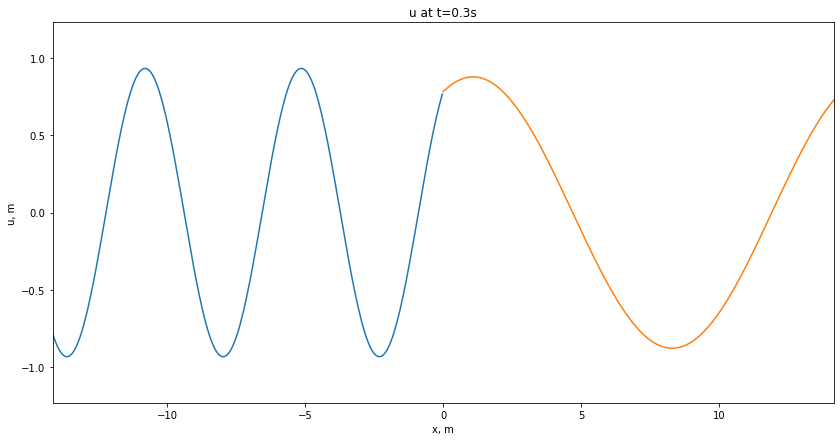

In [9]:
bdy.plot_expansion(t=0.3, get_disp=True)

### Animate displacement

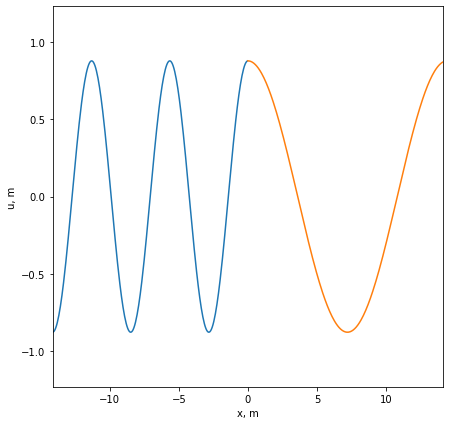

Saving figs/animation2.gif


In [10]:
os.makedirs('figs', exist_ok=True)
bdy.animate_displacement('figs/animation2.gif')

### Display animation of displacement
![SegmentLocal](figs/animation2.gif "segment")

## Scattering by two boundaries in series
To handle this we use the `MultipleScatterer` class

In [11]:
period = 4
lhs = ElasticString(m=2, period=period)
mid = ElasticString(kappa=13, period=period)
rhs = ElasticString(kappa=6, period=period)
s0 = Helmholtz1DBoundary(lhs, mid, position=0)
s1 = Helmholtz1DBoundary(mid, rhs, position=4)

In [12]:
for bdy in [s0, s1]:
    print(vars(bdy))
    bdy.solve()
    bdy.test_boundary_conditions()
    bdy.test_energy()
    bdy.test_power_input()

{'position': 0, 'media': [<pywave.scattering.elastic_string.ElasticString object at 0x7fd72bfd3f28>, <pywave.scattering.elastic_string.ElasticString object at 0x7fd72bfd3b70>], 'condition_types': [{'displacement': True}, {'displacement': True}]}
u(0) = 1.439607805437114 = 1.439607805437114
\sigma(0) = 2.4897569199005702j = 2.4897569199005702j
Boundary conditions are OK
Energy is OK
Test power input, from_left=True:
	-3.438525233229448, -3.4385252332294476
	OK
Test power input, from_left=False:
	4.383276815554534, 4.3832768155545345
	OK
{'position': 4, 'media': [<pywave.scattering.elastic_string.ElasticString object at 0x7fd72bfd3780>, <pywave.scattering.elastic_string.ElasticString object at 0x7fd72bfd41d0>], 'condition_types': [{'displacement': True}, {'displacement': True}]}
u(0) = 1.5954627333817362 = 1.5954627333817362
\sigma(0) = 2.2911318826993954j = 2.291131882699395j
Boundary conditions are OK
Energy is OK
Test power input, from_left=True:
	-4.2860235029662075, -4.2860235029662

In [13]:
ms = MultipleScatterer([s0, s1])
print(ms.xlim)
for med in ms.media:
    print(med.xlim)

(0.0, 4.0)
[-inf   0.]
[0. 4.]
[ 4. inf]


In [14]:
vars(ms)

{'scatterers': [<pywave.scattering.helmholtz_1d_boundary.Helmholtz1DBoundary at 0x7fd72bfc72b0>,
 'media': [<pywave.scattering.elastic_string.ElasticString at 0x7fd72bfd3f28>,
 'num_media': 3,
 'num_interior_media': 1,
 'slices': [slice(0, 1, None)],
 'num_unknowns': 1}

In [15]:
ms.solve()

In [16]:
ms.test_energy()
# ms.test_swap()

Energy is OK


In [17]:
ms.test_power_input()

Test power input, from_left=True:
	-3.1736796626444272, -3.1736796626444264
	OK
Test power input, from_left=False:
	2.748487211324101, 2.748487211324101
	OK


In [18]:
ms.test_boundary_conditions()


Test boundary conditions at boundary 0:
displacement = (0.6328263124898319+0.3770522407813619j) = (0.6328263124898319+0.3770522407813619j)?
stress = (1.6751989673618928+6.0741926497379835j) = (1.675198967361893+6.0741926497379835j)?

Test boundary conditions at boundary 1:
displacement = (0.18321340505767772+0.992225865420135j) = (0.1832134050576778+0.992225865420135j)?
stress = (-3.817737345530408-3.1427085258652876j) = (-3.8177373455304084-3.142708525865288j)?
Boundary conditions are OK


<AxesSubplot:title={'center':'u at t=0s'}, xlabel='x, m', ylabel='u, m'>

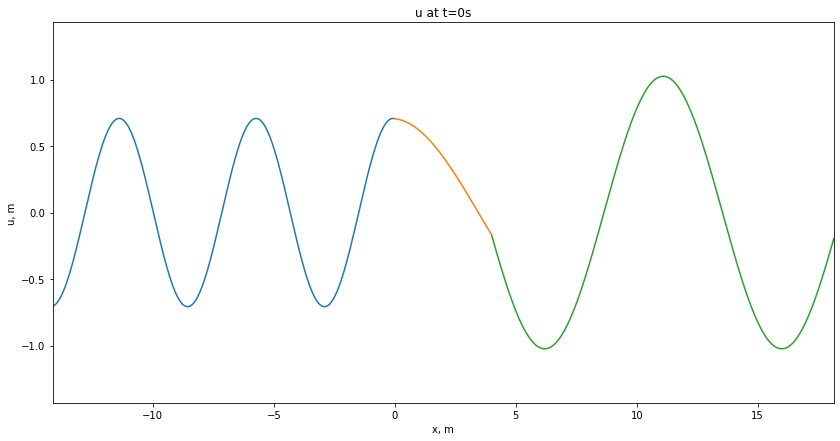

In [19]:
ms.plot_expansion()

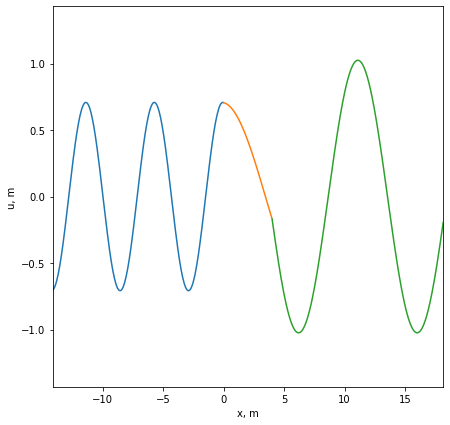

Saving figs/animation3.gif


In [20]:
ms.animate_displacement('figs/animation3.gif')

### Display animation of displacement
![SegmentLocal](figs/animation3.gif "segment")

## TODO
- improve plot (edges)
- MS
  - test_boundary_conditions (in base class)
- superposition
- time dependent?